# Test interannual versus LE ensemble spread

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
import scipy.stats as stats
import scipy.signal as signal
import glob
import math as m
import datetime

In [2]:
model_names  = ['CanESM5', 'MIROC6', 'GISS-E2-1-G', 'IPSL-CM6A-LR',
                'CNRM-CM6-1', 'NorCPM1'
]

month_names_short = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 
                     'Sep', 'Oct', 'Nov', 'Dec']

model_colors = [np.array([0.9,0.9,0.1]), np.array([0.9,0.1,0.9]), 
                np.array([0.1,0.9,0.9]), np.array([0.9,0.1,0.1]),
                np.array([0.1,0.1,0.9]), np.array([0.6,0.6,0.2]), 
                np.array([0.6,0.2,0.6]), np.array([0.2,0.6,0.6]),
                np.array([0.9,0.2,0.5])]

region_names_long = [
    'Beaufort Sea', 'Chukchi Sea', 'East Siberian Sea', 'Laptev Sea', 
    'Kara Sea', 'Barents Sea', 'Greenland Sea', 'Baffin Bay', 
    'Canadian Archipelago', 'Hudson Bay', 'Central Arctic', 'Bering Sea',
    'Baltic Sea', 'Sea of Okhotsk', 'Yellow Sea', 'Cook Inlet',
]

region_names_short = [
    'Beaufort', 'Chukchi', 'E.Siberian', 'Laptev', 'Kara', 'Barents', 
    'Greenland', 'Baffin', 'Canadian AA', 'Hudson', 'Central', 'Bering', 
    'Baltic', 'Okhotsk', 'Yellow', 'Cook',      
]

region_names_ac = [
    'BEAU', 'CHUK', 'EAST', 'LAPT', 'KARA', 'BARE', 'GREN', 'BAFF', 'CAA', 
    'HUDS', 'CENT', 'BERI', 'BALT', 'OKHO', 'YELL', 'COOK',
]

CMIP6_info = xr.open_dataset(
    '/glade/work/cwpowell/low-frequency-variability/raw_data/CMIP6_info/'\
    +'CMIP6_modeling_center_members_doi.nc'
)

In [63]:
def resample_boot2(time_period, data):
    '''
    Resample a 1D time series using a 2 year block boostrap size 
    with replacement
    
    Parameters
    ----------
    time_period : integer,
        For 1979-2020 use 42 as the total number of years in that time period
    data : 1 dimensional xarray dataarray,
        For 1979-2020 this is an array of shape [42] 
    
    Returns
    ----------
        2D xarray dataarray object of 1000 resamplings of the input data, 
        shape: (time_period, 1000)
    '''  
    #create an xarray dataarray of indexes for half the length of the 
    #time period, year_i coordinates 1,3,5...
    boot_2_first_ind = xr.DataArray(
        data   = np.random.randint(0,time_period-2, (1000,int(time_period/2))), 
        coords = {'resampling':np.arange(1,1001,1), 
                  'year_i':np.arange(1,time_period+1,2)},
        dims   = ['resampling', 'year_i'],
    )

    #create an identical dataarray but with each element incremented by 1,
    #year_i coordinates 2,4,6....
    boot_2_second_ind = (boot_2_first_ind+1).copy()
    boot_2_second_ind['year_i'] = np.arange(2,time_period+2,2)

    #concatenate the two arrays with the coordinates in order,
    #this allows a 2 year block boostrap size
    all_boot_2_ind = xr.concat((boot_2_first_ind, boot_2_second_ind), 
                               dim='year_i').sortby('year_i')
    
    #create an array with the starting element of the flattened array 
    #for each resampling 0, 42, 84...
    ind_base = np.repeat(np.arange(0,time_period*1000,time_period),time_period)
    
    #add together the base indexes (0,42,84...) with the randomly chosen 
    #indexes within the original data
    ind_1_d = np.ravel(all_boot_2_ind) + ind_base
    
    #copy the original data 1000 times as a 1D array so it will have the 
    #same indexes as we just made for ind_1_d
    data_1000 = np.ravel(np.tile(data,(time_period,1000)))
    
    #select the randomly generated indexes from the flattened copied 
    #original data, reshape and save to xarray dataarray
    resampled_boot_2 = xr.DataArray(
        data = np.reshape(data_1000[ind_1_d], (1000, time_period)),
        coords = {'resampling':np.arange(1,1001,1), 
                  'year_i':np.arange(1,time_period+1,1)},
        dims   = ['resampling', 'year_i'],
    )

    return(resampled_boot_2)

In [5]:
## Load the East Siberian Sea SIC data from obs and models
CDR_SIC = xr.open_dataset('/glade/work/cwpowell/low-frequency-variability/'\
    +'raw_data/sea_ice_obs/NSIDC_CDR_Regional_Average_SIC_1979_2021.nc')

CMIP6_SIC = {}

for model_name in model_names:
    temp_data = xr.open_dataset('/glade/work/cwpowell/low-frequency-variability/'\
    +'raw_data/regional_sea_ice_CMIP6/Regional_SIC_SIT_all_mem_{}_1850_2014.nc'.format(model_name))
    
    CMIP6_SIC[model_name] = temp_data['regional_SIC']

## Detrend with a 2 year lowpass filter

In [2]:
region_ = 3

ESS_detrend = {}
for model_i, model_name in enumerate(model_names):
    
    all_month_data = []
    for month_ in np.arange(1,13):

        ########################################################################
        #load the reduced datasets, each month and model for 30N+ and 1979-2020
        month_data = CMIP6_SIC[model_name].sel(region=region_).sel(
            time=CMIP6_SIC[model_name]['time.month']==month_)

        ########################################################################            
        #set up the Butterworth filter. cutoff freq = 0.25 the Nyquist frequency
        #cutoff = 0.25*0.5*samp freq = 2 years. Order = 5th
        b, a = signal.butter(5, 0.25, btype='lowpass') 

        #compute anomalies relative to 2 year filter (filtfilt = forward/back)
        #apply to axis=1 which is the time dimension
        all_month_data.append(month_data - signal.filtfilt(b, a, month_data, axis=1))
        
    ESS_detrend[model_name] = xr.concat((all_month_data), dim='time')    

## Detrend with a linear trend

In [1]:
region_ = 3

ESS_detrend_linear = {}
for model_i, model_name in enumerate(model_names):
    
    all_month_data = []
    for month_ in np.arange(1,13):

        ########################################################################
        #load the reduced datasets, each month and model for 30N+ and 1979-2020
        month_data = CMIP6_SIC[model_name].sel(region=region_).sel(
            time=CMIP6_SIC[model_name]['time.month']==month_)

        all_month_data.append(month_data*0 + signal.detrend(month_data, axis=1))
        
    ESS_detrend_linear[model_name] = xr.concat((all_month_data), dim='time')    

## Resample 10,000 times each member for all months

In [6]:
ESS_resampled = {}
for model_name in model_names:
    print(datetime.datetime.now(), model_name)
    
    all_month_data = []
    for month_ in np.arange(1,13):
    
        all_mem = []
        ESS_data = ESS_detrend[model_name].sel(
            time=ESS_detrend[model_name]['time.month']==month_).sel(
            time=slice('1973','2014'))
        for mem_ in ESS_data['member']:

            all_mem.append(resample_boot2(42, ESS_data.sel(member=mem_)))

        all_model_data = xr.concat((all_mem),dim='member')
        all_model_data['member'] = ESS_data['member'].copy()
        all_month_data.append(all_model_data.std('year_i').std('resampling'))

    ESS_resampled[model_name] = xr.concat((all_month_data), dim='month')
    ESS_resampled[model_name]['month'] = np.arange(1,13)

2022-08-02 14:23:20.245011 CanESM5
2022-08-02 14:23:25.247695 MIROC6
2022-08-02 14:23:28.956772 GISS-E2-1-G
2022-08-02 14:23:32.256277 IPSL-CM6A-LR
2022-08-02 14:23:34.916244 CNRM-CM6-1
2022-08-02 14:23:36.578980 NorCPM1


In [27]:
ESS_resampled_linear = {}
for model_name in model_names:
    print(datetime.datetime.now(), model_name)
    
    all_month_data = []
    for month_ in np.arange(1,13):
    
        all_mem = []
        ESS_data = ESS_detrend_linear[model_name].sel(
            time=ESS_detrend_linear[model_name]['time.month']==month_).sel(
            time=slice('1973','2014'))
        for mem_ in ESS_data['member']:

            all_mem.append(resample_boot2(42, ESS_data.sel(member=mem_)))

        all_model_data = xr.concat((all_mem),dim='member')
        all_model_data['member'] = ESS_data['member'].copy()
        all_month_data.append(all_model_data.std('year_i').std('resampling'))

    ESS_resampled_linear[model_name] = xr.concat((all_month_data), dim='month')
    ESS_resampled_linear[model_name]['month'] = np.arange(1,13)

2022-08-02 14:34:01.236271 CanESM5
2022-08-02 14:34:05.550758 MIROC6
2022-08-02 14:34:08.905755 GISS-E2-1-G
2022-08-02 14:34:11.757630 IPSL-CM6A-LR
2022-08-02 14:34:13.908788 CNRM-CM6-1
2022-08-02 14:34:15.330374 NorCPM1


### Calculate $\sigma_{LE}$

In [28]:
sigma_LE = {}
sigma_LE_linear = {}
for model_name in model_names:
    sigma_LE[model_name] = ESS_detrend[model_name].sortby('time').sel(
        time=slice('1977','2014')).groupby('time.month').std('time').std('member')
    
    sigma_LE_linear[model_name] = ESS_detrend_linear[model_name].sortby('time').sel(
        time=slice('1977','2014')).groupby('time.month').std('time').std('member')

### Plot $\sigma_{mem}$/$\sigma_{mem}$

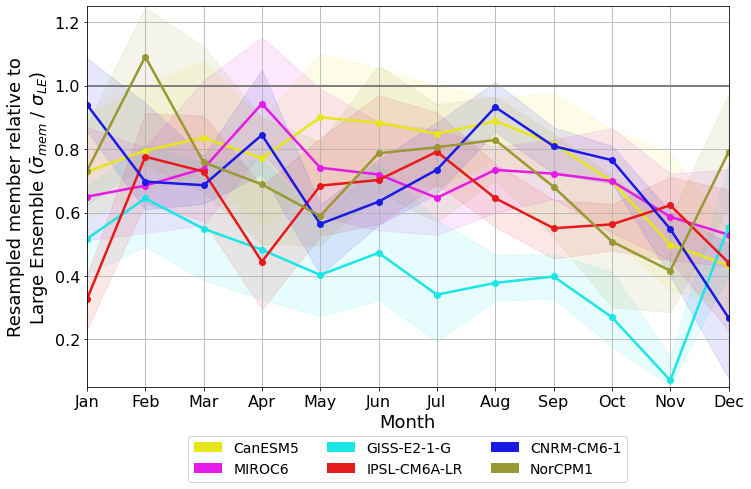

In [33]:
#plot sigma ratios with median and interquartile ranges
sig_mem = ESS_resampled_linear.copy()

sig_LE = sigma_LE_linear.copy()

fig = plt.figure(figsize=[11.5,7])
plt.axhline(1, c='0.5', linewidth=2)

for model_i, model_name in enumerate(model_names):
    
    mem_len = len(sig_mem[model_name]['member'].values)
    #define the upper and lower quarties of sigma_mem members
    upper = sig_mem[model_name].where(
        sig_mem[model_name].rank('member')==m.floor(mem_len*0.75)).max('member')
    lower = sig_mem[model_name].where(
        sig_mem[model_name].rank('member')==m.ceil(mem_len*0.25)).max('member')
    
    plt.plot(month_names_short, 
        sig_mem[model_name].median('member')/sig_LE[model_name], 
        c=model_colors[model_i], linewidth=2.5, marker='o', markersize=6)

    plt.fill_between(month_names_short, upper/sig_LE[model_name], 
                     lower/sig_LE[model_name], color=model_colors[model_i], 
                     alpha=0.1)

    #########################################################################

plt.xticks(np.arange(0,12,1))
plt.grid()
plt.xlim(0,11)
plt.ylim(0.05,1.25)

plt.xlabel('Month', fontsize=18)

plt.ylabel('Resampled member relative to'+'\n'
           +r'Large Ensemble ($\bar{\sigma}_{mem} \ / \ \sigma_{LE}$)', 
           fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16);

legend_elements = [Patch(facecolor=model_colors[0], label=model_names[0]),
                   Patch(facecolor=model_colors[1], label=model_names[1]),
                   Patch(facecolor=model_colors[2], label=model_names[2]),
                   Patch(facecolor=model_colors[3], label=model_names[3]),
                   Patch(facecolor=model_colors[4], label=model_names[4]),
                   Patch(facecolor=model_colors[5], label=model_names[5]),]

extra_legend = plt.legend(handles=legend_elements, 
                          bbox_to_anchor=(0.5, -0.24), loc='lower center', 
                          borderaxespad=-0.25, ncol=3, fontsize=14)

fig.savefig('/glade/work/cwpowell/low-frequency-variability/figures/'\
           +'Sigma_LE_mem_region3.pdf', bbox_inches='tight')

# Look at all regions and all models with >=20 members

In [239]:
#load raw SIC data for the largest ensembles with 20+ members
LE_models = [
    'CanESM5', 'MIROC6', 'GISS-E2-1-G', 'IPSL-CM6A-LR', 'CNRM-CM6-1', 'NorCPM1',
    'GISS-E2-1-H', 'EC-Earth3'
]

var_ = 'regional_SIV'
all_CMIP6_raw = {}

for model_name in LE_models:
    try:
        to_concat = glob.glob(
            '/glade/work/cwpowell/low-frequency-variability/raw_data/'\
            +f'regional_sea_ice_CMIP6/Regional_SIC_SIT_{model_name}_*.nc')

        mem_concat = []

        for file_ in to_concat:
            temp = xr.open_dataset(file_)
            mem_concat.append(temp[var_])

        all_CMIP6_raw[model_name] = xr.concat((mem_concat),
                                              dim='member').sortby('member')
    
    except ValueError:
        print(model_name)

In [240]:
#detrend with 2 year lowpass filter, leaves interannual
lowpass_filt = {}

start_yr = 1920
end_yr = 2014

for model_name in LE_models:
    try:
        model_data = all_CMIP6_raw[model_name].sel(
            time=slice(str(start_yr), str(end_yr)))

        all_months = []
        for month_ in np.arange(1,13):

            #load the reduced datasets, each month and model
            month_data = model_data.sel(time=model_data['time.month']==month_)

            #set up the Butterworth filter. cutoff freq = 0.25 the Nyquist frequency
            #cutoff = 0.25*0.5*samp freq = 2 years. Order = 5th
            b, a = signal.butter(5, 0.25, btype='lowpass') 

            #compute anomalies relative to 2 year filter (filtfilt = forward/back)
            #apply to axis=3 which is the time dimension
            all_months.append(
                month_data - signal.filtfilt(b, a, month_data, axis=2)
            )

        lowpass_filt[model_name] = xr.concat((all_months), dim='time')    
    
    except KeyError:
        print(model_name)


In [241]:
#resample 1000 times (takes about 20 min for 7 regions)
resampled = {}
for model_name in LE_models:
    print(datetime.datetime.now(), model_name)
    
    all_months = []
    for month_ in np.arange(1,13):
    
        filt_data = lowpass_filt[model_name].sel(
            time=lowpass_filt[model_name]['time.month']==month_)
        
        all_mems = []
        for mem_ in filt_data['member'].values:
            
            all_regions = []
            for region_ in [1,2,3,4,5,6,11]:
                temp_resamp = resample_boot2(96, filt_data.sel(
                    member=mem_).sel(region=region_))
                
                all_regions.append(temp_resamp.std('year_i').std('resampling'))
                
            all_regions_xr = xr.concat((all_regions), dim='region')
            all_regions_xr['region'] = [1,2,3,4,5,6,11]
            all_mems.append(all_regions_xr)

        all_mems_xr = xr.concat((all_mems),dim='member')
        all_mems_xr['member'] = filt_data['member'].values.copy()
        all_months.append(all_mems_xr)

    resampled[model_name] = xr.concat((all_months), dim='month')
    resampled[model_name]['month'] = np.arange(1,13)

2022-10-12 11:56:27.996739 CanESM5
2022-10-12 12:00:41.887543 MIROC6
2022-10-12 12:03:56.486934 GISS-E2-1-G
2022-10-12 12:06:42.626824 IPSL-CM6A-LR
2022-10-12 12:10:38.400590 NorCPM1
2022-10-12 12:12:33.683729 GISS-E2-1-H
2022-10-12 12:14:02.717438 EC-Earth3


In [242]:
#save the 1000 resamplings of regional SIC, SIT, SIV
for model_name in LE_models:
    to_save = xr.Dataset({'SIV':resampled[model_name].copy()})
    
    doi_ = CMIP6_info['doi'].sel(model=model_name).values
    
    to_save.attrs = {
        'Description': '2 year lowpass filtered monthly regional sea ice '\
            +'volume [m3], resampled 1000 times with a 2 year block '\
            +'bootstrap size with replacement for years 1920-2014 by region '\
            +'and month. Regions as defined for NSIDC MASIE-NH Version 1',
        'Timestamp'  : str(datetime.datetime.utcnow().strftime(
            "%H:%M UTC %a %Y-%m-%d")),
        'Data source': f'CMIP6 historical model output from {model_name}, '\
            +f'doi:{doi_}',
        'Analysis'   : 'https://github.com/chrisrwp/low-frequency-variability/'\
            +'blob/main/interannual_low_frequency/'\
            +'Ratio_low_interannual_variability.ipynb'
    }
    
    to_save.to_netcdf(
        '/glade/work/cwpowell/low-frequency-variability/resampling/'\
        +f'Resampled_SIV_1000_low_pass_2yr_1920_2014_{model_name}.nc')

In [106]:
# #make Sigma_LE NetCDF files
# for model_name in LE_models:
    
#     no_nan = lowpass_filt[model_name].where(
#         ~xr.ufuncs.isnan(lowpass_filt[model_name]), drop=True)
    
#     Sigma_LE = xr.Dataset({'Sigma_LE':no_nan.groupby('time.month').std(
#         'time').std('member')})
    
#     doi_ = CMIP6_info['doi'].sel(model=model_name).values
    
#     Sigma_LE.attrs = {
#         'Description': '2 year lowpass filtered monthly regional sea ice '\
#             +'thickness, standard deviation between members by month and '\
#             +'region, 1920-2014. Regions as defined for NSIDC MASIE-NH '\
#             +'Version 1',
#         'Timestamp'  : str(datetime.datetime.utcnow().strftime(
#             "%H:%M UTC %a %Y-%m-%d")),
#         'Data source': f'CMIP6 historical model output from {model_name}, '\
#             +f'doi:{doi_}',
#         'Analysis'   : 'https://github.com/chrisrwp/low-frequency-variability/'\
#             +'blob/main/interannual_low_frequency/'\
#             +'Ratio_low_interannual_variability.ipynb'
#     }
    
#     Sigma_LE.to_netcdf(
#         '/glade/work/cwpowell/low-frequency-variability/resampling/'\
#         +f'Sigma_LE_SIT_low_pass_2yr_1920_2014_{model_name}.nc')

In [215]:
#open the resampled and Sigma_LE files
var_ = 'SIC'

Sigma_LE = {}
Sigma_mem = {}

for model_name in LE_models:
    LE_temp = xr.open_dataset(
        '/glade/work/cwpowell/low-frequency-variability/resampling/'\
        +f'Sigma_LE_{var_}_low_pass_2yr_1920_2014_{model_name}.nc')
    
    mem_temp = xr.open_dataset(
        '/glade/work/cwpowell/low-frequency-variability/resampling/'\
        +f'Resampled_{var_}_1000_low_pass_2yr_1920_2014_{model_name}.nc')
    
    Sigma_LE[model_name] = LE_temp['Sigma_LE']
    Sigma_mem[model_name] = mem_temp[var_]

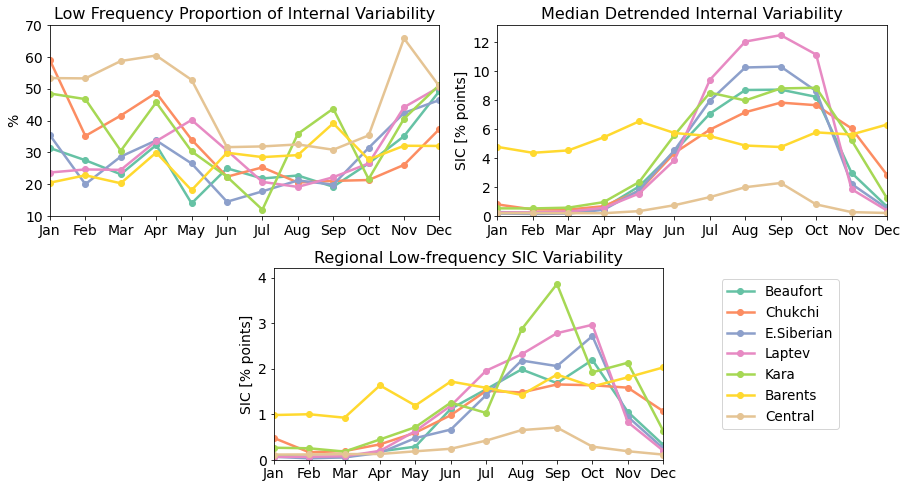

In [220]:
#calculate the average SD between ensemble members by month and region
LE_SD_filt = []
LE_SD = []
for model_name in LE_models:
    LE_SD_filt.append(lowpass_filt[model_name].std('member').groupby(
        'time.month').mean('time'))
    LE_SD.append(all_CMIP6_raw[model_name].std('member').groupby(
        'time.month').mean('time'))

LE_SD_filt = xr.concat((LE_SD_filt), dim='model').median('model')*100
LE_SD = xr.concat((LE_SD), dim='model').median('model')*100

#define the colors
cmap = plt.cm.Set2  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)] #all the colors in the cmap

fig = plt.figure(figsize=[15,8])

#set the subplot layout
gs = gridspec.GridSpec(4, 4)
ax1 = plt.subplot(gs[:2, :2])
ax2 = plt.subplot(gs[:2, 2:])
ax3 = plt.subplot(gs[2:4, 1:3])

for region_i, region_ in enumerate([1,2,3,4,5,6,11]):
    ###### proportion subplot, 1 - (sigma_mem to sigma_LE) #######
    ensemble_av = []

    for model_name in LE_models[:8]:
        ensemble_av.append(
            Sigma_mem[model_name].sel(region=region_).median('member').values/
            Sigma_LE[model_name].sel(region=region_).values
        )
        
    temp_meidan = (np.ones(12) - np.median(ensemble_av,axis=0))*100
    
    ax1.plot(month_names_short, temp_meidan, marker='o', markersize=6, 
             color=cmaplist[region_i], linewidth=2.5)
    
    ax1.set_xlim(0,11)
    ax1.set_ylim(10,70) #SIC 10,70, SIT 0,50
    ax1.set_yticks(np.arange(10,71,10)) #SIC 10,71,10, SIT 0,51,10
    ax1.tick_params(axis='both', labelsize=14)
    ax1.set_ylabel('%', fontsize=14)
    ax1.set_title('Low Frequency Proportion of Internal Variability',
                  fontsize=16)
    
    ###### absolute value subplot, SD between filtered members ######
    ax2.plot(month_names_short, LE_SD_filt.sel(region=region_), marker='o',
             markersize=6, color=cmaplist[region_i], linewidth=2.5)
    
    ax2.set_xlim(0,11)
    ax2.set_ylim(0,13.2) #SIC 0,13.2, SIT 0,33.5
    ax2.set_yticks(np.arange(0,13,2)) #SIC 13,2, SIT 31,5, SIV
    ax2.tick_params(axis='both', labelsize=14)
    ax2.set_title('Median Detrended Internal Variability', fontsize=16)
    ax2.set_ylabel('SIC [% points]', fontsize=14)

    
    ###### % x absolute value subplot ######
    ax3.plot(month_names_short, temp_meidan/100 * LE_SD_filt.sel(region=region_), 
             marker='o', markersize=6, color=cmaplist[region_i], linewidth=2.5,
             label=region_names_short[region_-1])
    
    ax3.set_xlim(0,11)
    ax3.set_ylim(0,4.2) #SIC 0,4.2, SIT 0,9, SIV
    ax3.set_yticks(np.arange(0,4.1,1)) #SIC 4.1,1, SIT 9,1
    ax3.tick_params(axis='both', labelsize=14)
    ax3.set_title('Regional Low-frequency SIC Variability', 
                  fontsize=16)
    ax3.set_ylabel(r'SIC [% points]', fontsize=14)
    
    ax3.legend(bbox_to_anchor=(1.3, 0.18), loc='lower center', 
           borderaxespad=-0.25, ncol=1, fontsize=13.5)
    
plt.subplots_adjust(hspace=0.75, wspace=0.35)

fig.savefig('/glade/work/cwpowell/low-frequency-variability/figures/'\
           +'Low_frequency_component_regional_SIC.pdf')

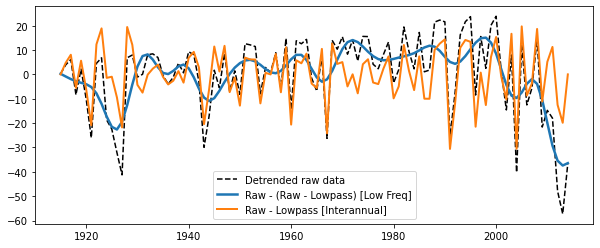

In [291]:
raw_data = all_CMIP6_raw['CanESM5'].sel(time=all_CMIP6_raw['CanESM5']['time.month']==10).isel(member=0).sel(region=3).sel(time=slice('1915','2014'))*100
det_with_lowpass = lowpass_filt['CanESM5'].sel(time=lowpass_filt['CanESM5']['time.month']==10).isel(member=0).sel(region=3)*100

plt.figure(figsize=[10,4])
plt.plot(np.arange(1915,2015), signal.detrend(raw_data), label='Detrended raw data', c='k', linestyle='--')
plt.plot(np.arange(1915,2015), signal.detrend(raw_data) - det_with_lowpass, label='Raw - (Raw - Lowpass) [Low Freq]', linewidth=2.5)
plt.plot(np.arange(1915,2015), det_with_lowpass, label='Raw - Lowpass [Interannual]', linewidth=2)
plt.legend()

In [155]:
#calculate detreneded SD average across members and models
detrended_SD = []
mem_count = 0
for model_name in CMIP6_info['model'].values:
    
    try:
        no_nan_data = all_CMIP6_raw[model_name].where(~xr.ufuncs.isnan(
            all_CMIP6_raw[model_name]),drop=True)
        
        if model_name == 'CNRM-CM6-1':
            no_nan_data = no_nan_data.fillna(0)
        
        temp_detrend = no_nan_data*0 + signal.detrend(no_nan_data, axis=2)
        
        temp_detrend = temp_detrend.sel(time=slice('1915','2014')
            ).groupby('time.month').std('time')
        
        temp_detrend['member'] = np.arange(mem_count, 
            mem_count + len(no_nan_data['member'].values))
                                           
        mem_count = mem_count + len(no_nan_data['member'].values)
        
        detrended_SD.append(temp_detrend)
    
    except KeyError:
        print(model_name, 'NOT AVAILIBLE')
    except ValueError:
        print(model_name, 'NANs', len(all_CMIP6_raw[model_name]['member']))
    except ZeroDivisionError:
        print(model_name, 'Zero Error', len(all_CMIP6_raw[model_name]['member']))
        
median_SD = xr.concat((detrended_SD),dim='member').median('member')

AWI-CM-1-1-MR NOT AVAILIBLE
AWI-ESM-1-1-LR NOT AVAILIBLE
CNRM-CM6-1-HR NANs 5
GFDL-CM4 NANs 8
GISS-E2-1-G-CC Zero Error 1
HadGEM3-GC31-MM NANs 20
IITM-ESM NOT AVAILIBLE
KACE-1-0-G NOT AVAILIBLE
KIOST-ESM NANs 5
MCM-UA-1-0 Zero Error 2


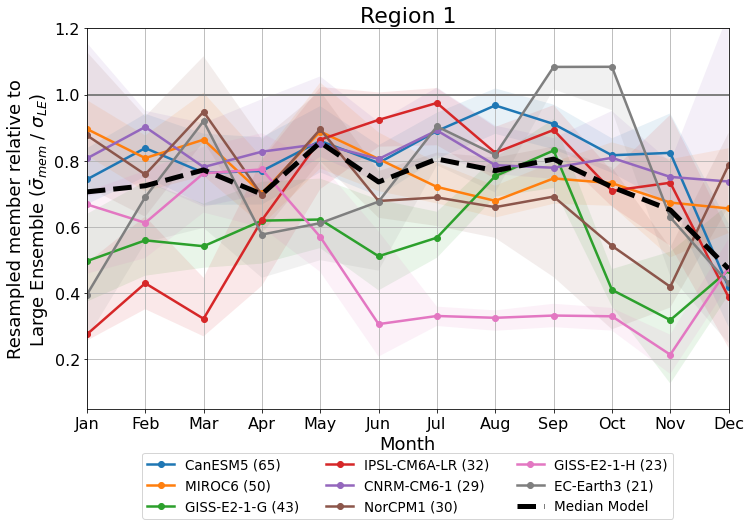

In [301]:
#plot sigma ratios with median and interquartile ranges
sig_mem = Sigma_mem.copy()
sig_LE = Sigma_LE.copy()

region_ = 1

fig = plt.figure(figsize=[11.5,7])
plt.axhline(1, c='0.5', linewidth=2)

ensemble_av = []
for model_i, model_name in enumerate(LE_models[:8]):
    
    mem_len = len(np.unique(sig_mem[model_name]['member'].values))
    #define the upper and lower quarties of sigma_mem members
    upper = sig_mem[model_name].where(
        sig_mem[model_name].rank('member')==m.floor(mem_len*0.75)).max(
        'member').sel(region=region_)
    lower = sig_mem[model_name].where(
        sig_mem[model_name].rank('member')==m.ceil(mem_len*0.25)).max(
        'member').sel(region=region_)
    
    plt.plot(month_names_short, 
        sig_mem[model_name].median('member').sel(region=region_)\
             /sig_LE[model_name].sel(region=region_), 
        linewidth=2.5, marker='o', markersize=6, 
             label=model_name+f' ({mem_len})')

    plt.fill_between(month_names_short, upper/sig_LE[model_name].sel(
        region=region_), lower/sig_LE[model_name].sel(region=region_),
        alpha=0.1)
    
    ensemble_av.append(
            sig_mem[model_name].median('member').sel(region=region_)\
            /sig_LE[model_name].sel(region=region_)
        )
        
plt.plot(month_names_short, np.median(ensemble_av,axis=0),
         color='k', linestyle='--', linewidth=5, label='Median Model');

    #########################################################################

plt.xticks(np.arange(0,12,1))
plt.grid()
plt.xlim(0,11)
plt.ylim(0.05,1.2)

plt.xlabel('Month', fontsize=18)

plt.ylabel('Resampled member relative to'+'\n'
           +r'Large Ensemble ($\bar{\sigma}_{mem} \ / \ \sigma_{LE}$)', 
           fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16);

extra_legend = plt.legend(bbox_to_anchor=(0.5, -0.28), loc='lower center', 
                          borderaxespad=-0.25, ncol=3, fontsize=13.5)

plt.title(f'Region {region_}', fontsize=22);